In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import RandomForestModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mae, r2_score
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


COLORS = {
    'IHSG': '#2E7D32',           # Green (primary)
    'IHSG_light': '#4CAF50',
    'IHSG_dark': '#1B5E20',    
    'STI': '#1976D2',            # Blue for regional index
    'Gold': '#FFD700',           # Gold color
    'Coal': '#FF5722',           # Orange-red
    'Copper': '#795548',         # Brown
    'Silver': '#9E9E9E',         # Gray
    'Tin': '#607D8B',            # Blue-gray
    'Nickel': '#FF9800',         # Orange
    'train': '#2E7D32',
    'actual': '#1976D2',
    'predicted': '#D32F2F',
    'error': '#9E9E9E',
    'split_line': '#616161',
}

COLOR_PALETTE = ['#2E7D32', '#D32F2F', '#F57C00', '#1976D2', '#7B1FA2', '#C2185B', '#FFD700']

# =========================================================================
# MATPLOTLIB THESIS STYLE
# =========================================================================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100          # Display DPI
plt.rcParams['savefig.dpi'] = 300         # Export DPI (publication quality)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# Font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Georgia']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Line settings
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 0.8

# Grid settings
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5

# Legend settings
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.edgecolor'] = '0.8'

print("Libraries imported successfully!")
print("Thesis color palette and matplotlib style configured.")

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.


Libraries imported successfully!
Thesis color palette and matplotlib style configured.


## 2. Load and Merge Data

In [2]:
# Load all datasets
print("="*60)
print("LOADING DATASETS")
print("="*60)

# IHSG (target) - Indonesian format dd/mm/yyyy
ihsg = pd.read_csv('dataset/ihsg_daily.csv')
ihsg['Date'] = pd.to_datetime(ihsg['Date'], format='%d/%m/%Y')
ihsg.columns = ['Date', 'IHSG']
print(f"IHSG: {len(ihsg)} rows, {ihsg['Date'].min()} to {ihsg['Date'].max()}")

# STI - Indonesian format dd/mm/yyyy
sti = pd.read_csv('dataset/STI.csv')
sti['Date'] = pd.to_datetime(sti['Date'], format='%d/%m/%Y')
sti.columns = ['Date', 'STI']
print(f"STI: {len(sti)} rows, {sti['Date'].min()} to {sti['Date'].max()}")

# Gold - Indonesian format dd/mm/yyyy
gold = pd.read_csv('dataset/Gold.csv')
gold['Date'] = pd.to_datetime(gold['Date'], format='%d/%m/%Y')
gold.columns = ['Date', 'Gold']
print(f"Gold: {len(gold)} rows, {gold['Date'].min()} to {gold['Date'].max()}")

# Commodities - US format mm/dd/yyyy
coal = pd.read_csv('dataset/Coal.csv')
coal['Date'] = pd.to_datetime(coal['Date'], format='%m/%d/%Y')
coal.columns = ['Date', 'Coal']
print(f"Coal: {len(coal)} rows, {coal['Date'].min()} to {coal['Date'].max()}")

copper = pd.read_csv('dataset/Copper.csv')
copper['Date'] = pd.to_datetime(copper['Date'], format='%m/%d/%Y')
copper.columns = ['Date', 'Copper']
print(f"Copper: {len(copper)} rows, {copper['Date'].min()} to {copper['Date'].max()}")

silver = pd.read_csv('dataset/Silver.csv')
silver['Date'] = pd.to_datetime(silver['Date'], format='%m/%d/%Y')
silver.columns = ['Date', 'Silver']
print(f"Silver: {len(silver)} rows, {silver['Date'].min()} to {silver['Date'].max()}")

tin = pd.read_csv('dataset/Tin.csv')
tin['Date'] = pd.to_datetime(tin['Date'], format='%m/%d/%Y')
tin.columns = ['Date', 'Tin']
print(f"Tin: {len(tin)} rows, {tin['Date'].min()} to {tin['Date'].max()}")

nickel = pd.read_csv('dataset/Nickel.csv')
nickel['Date'] = pd.to_datetime(nickel['Date'], format='%m/%d/%Y')
nickel.columns = ['Date', 'Nickel']
print(f"Nickel: {len(nickel)} rows, {nickel['Date'].min()} to {nickel['Date'].max()}")

LOADING DATASETS
IHSG: 2660 rows, 2015-01-02 00:00:00 to 2025-12-30 00:00:00
STI: 2766 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Gold: 2857 rows, 2015-01-01 00:00:00 to 2025-12-31 00:00:00
Coal: 2839 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Copper: 2780 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Silver: 2857 rows, 2015-01-01 00:00:00 to 2025-12-31 00:00:00
Tin: 2780 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Nickel: 2774 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00


In [3]:
# Merge all datasets on Date (inner join to get common dates)
print("\n" + "="*60)
print("MERGING DATASETS")
print("="*60)

# Start with IHSG as base
df = ihsg.copy()

# Merge each dataset (Gold added)
for dataset, name in [(sti, 'STI'), (gold, 'Gold'), (coal, 'Coal'), (copper, 'Copper'), 
                       (silver, 'Silver'), (tin, 'Tin'), (nickel, 'Nickel')]:
    df = df.merge(dataset, on='Date', how='inner')
    print(f"After merging {name}: {len(df)} rows")

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

print(f"\n✅ Final merged dataset: {len(df)} rows")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Columns: {df.columns.tolist()}")


MERGING DATASETS
After merging STI: 2620 rows
After merging Gold: 2620 rows
After merging Coal: 2620 rows
After merging Copper: 2570 rows
After merging Silver: 2570 rows
After merging Tin: 2570 rows
After merging Nickel: 2564 rows

✅ Final merged dataset: 2564 rows
Date range: 2015-01-02 00:00:00 to 2025-12-30 00:00:00
Columns: ['Date', 'IHSG', 'STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']


In [4]:
# Display merged data
print("="*60)
print("MERGED DATA PREVIEW")
print("="*60)
df.head(10)

MERGED DATA PREVIEW


,Date,IHSG,STI,Gold,Coal,Copper,Silver,Tin,Nickel
0,2015-01-02,5242.769,3370.59,1188.39,61.30,6255.0,15.7465,19645,14830
1,2015-01-05,5219.995,3328.28,1204.86,61.25,6145.0,16.1885,19495,15200
2,2015-01-06,5169.060,3281.95,1218.58,61.45,6145.0,16.5365,19775,15260
3,2015-01-07,5207.118,3298.36,1211.41,60.60,6115.0,16.5354,19700,15550
4,2015-01-08,5211.828,3345.11,1208.79,60.60,6104.0,16.3651,19780,15550
5,2015-01-09,5216.665,3338.44,1223.25,60.40,6090.0,16.5050,19550,15300
6,2015-01-12,5187.933,3344.89,1233.31,60.05,6017.0,16.5825,19900,15100
7,2015-01-13,5214.359,3341.07,1230.64,60.30,5860.0,17.0524,19525,14650
8,2015-01-14,5159.668,3326.16,1228.72,60.05,5548.0,16.8571,19375,14310
9,2015-01-15,5188.712,3338.84,1262.75,60.30,5630.0,16.9468,19355,14475


In [5]:
# Check data types and missing values
print("="*60)
print("DATA TYPES & MISSING VALUES")
print("="*60)
df.info()
print("\n" + "="*60)
print("MISSING VALUES PER COLUMN")
print("="*60)
print(df.isnull().sum())

DATA TYPES & MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2564 non-null   datetime64[ns]
 1   IHSG    2564 non-null   float64       
 2   STI     2564 non-null   float64       
 3   Gold    2564 non-null   float64       
 4   Coal    2564 non-null   float64       
 5   Copper  2564 non-null   float64       
 6   Silver  2564 non-null   float64       
 7   Tin     2564 non-null   int64         
 8   Nickel  2564 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 180.4 KB

MISSING VALUES PER COLUMN
Date      0
IHSG      0
STI       0
Gold      0
Coal      0
Copper    0
Silver    0
Tin       0
Nickel    0
dtype: int64


In [6]:
# Descriptive statistics
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df.describe().round(2)

DESCRIPTIVE STATISTICS


,Date,IHSG,STI,Gold,Coal,Copper,Silver,Tin,Nickel
count,2564,2564.00,2564.00,2564.00,2564.00,2564.00,2564.00,2564.00,2564.00
mean,2020-06-24 15:01:57.940717568,6185.65,3233.99,1768.07,123.94,7363.58,21.89,23718.21,15524.34
min,2015-01-02 00:00:00,3937.63,2233.48,1051.10,48.50,4331.00,11.98,13250.00,7595.00
25%,2017-09-28 18:00:00,5434.55,3065.02,1270.66,67.75,5850.75,16.48,18184.50,11863.00
50%,2020-06-20 12:00:00,6203.81,3212.52,1696.95,99.38,6903.00,19.03,20865.00,14977.50
75%,2023-03-14 06:00:00,6880.91,3356.28,1932.08,135.01,9077.38,24.79,29057.75,17898.50
max,2025-12-30 00:00:00,8710.70,4655.38,4484.47,457.80,12558.50,76.29,47540.00,48078.00
std,NaN,924.65,384.70,666.67,87.57,1817.12,7.97,7345.38,5061.51


## 3. Exploratory Data Analysis (EDA)

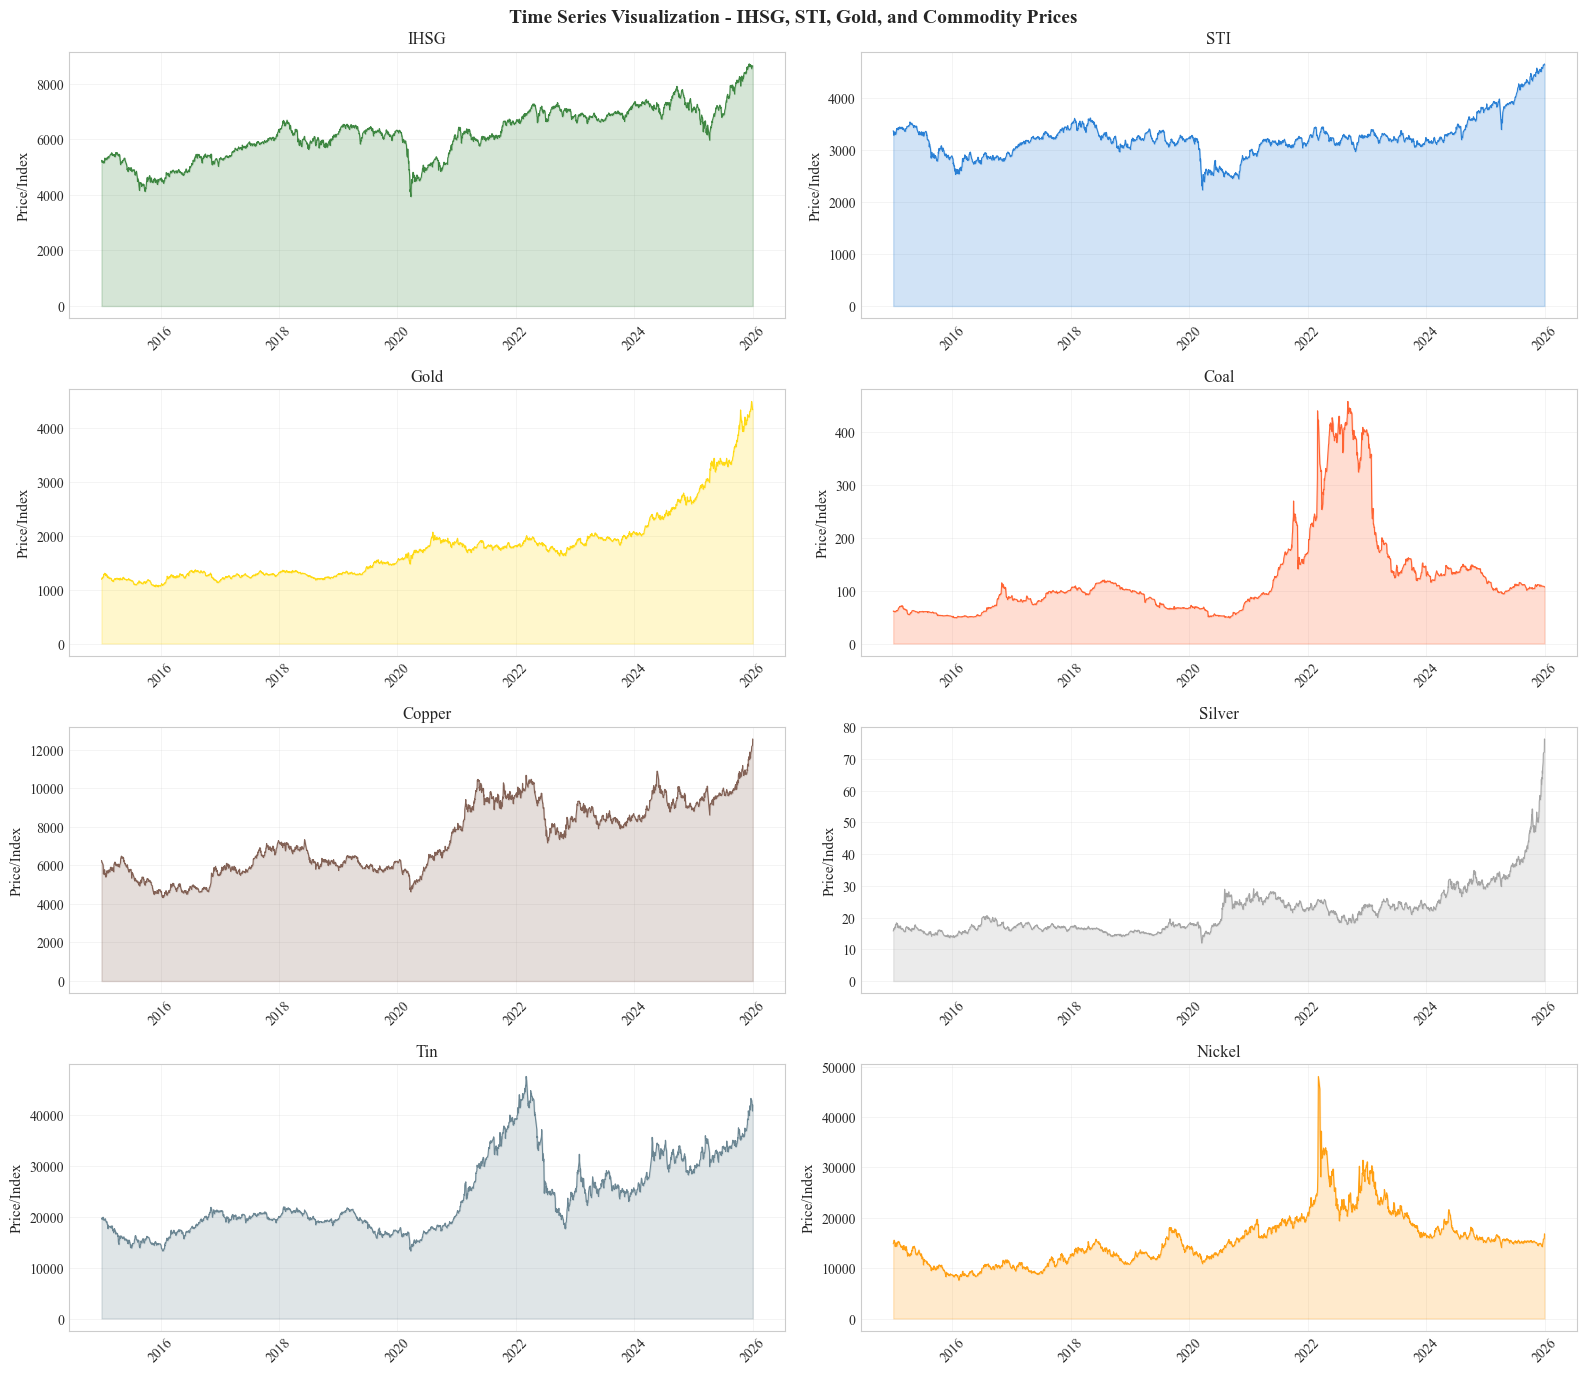

Figure saved: model2-figure/model2_eda_timeseries.png (300 DPI)


In [7]:
# Visualization: Time series plots with thesis colors
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
fig.suptitle('Time Series Visualization - IHSG, STI, Gold, and Commodity Prices', fontsize=14, fontweight='bold')

# Define colors from thesis palette (Gold added)
plot_config = [
    ('IHSG', COLORS['IHSG']),
    ('STI', COLORS['STI']),
    ('Gold', COLORS.get('Gold', '#FFD700')),  # Gold color
    ('Coal', COLORS['Coal']),
    ('Copper', COLORS['Copper']),
    ('Silver', COLORS['Silver']),
    ('Tin', COLORS['Tin']),
    ('Nickel', COLORS['Nickel'])
]

for idx, (col, color) in enumerate(plot_config):
    ax = axes[idx // 2, idx % 2]
    ax.plot(df['Date'], df[col], color=color, linewidth=0.8, alpha=0.9)
    ax.set_title(f'{col}', fontsize=12)
    ax.set_ylabel('Price/Index')
    ax.fill_between(df['Date'], df[col], alpha=0.2, color=color)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model2-figure/model2_eda_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_eda_timeseries.png (300 DPI)")

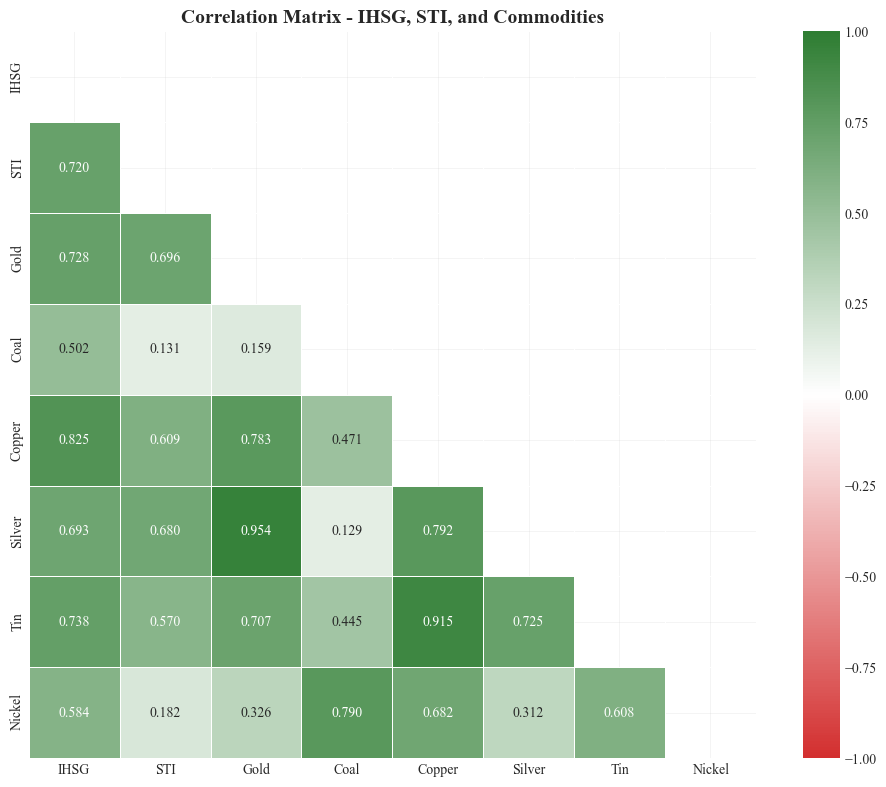

Figure saved: model2-figure/model2_correlation_matrix.png (300 DPI)

CORRELATION WITH IHSG
Copper          : +0.8253 (Strong Positive)
Tin             : +0.7376 (Strong Positive)
Gold            : +0.7279 (Strong Positive)
STI             : +0.7199 (Strong Positive)
Silver          : +0.6927 (Moderate Positive)
Nickel          : +0.5843 (Moderate Positive)
Coal            : +0.5023 (Moderate Positive)


In [8]:
# Correlation Analysis
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = df.drop('Date', axis=1).corr()

# Custom colormap: Green (positive with IHSG) to Red (negative)
from matplotlib.colors import LinearSegmentedColormap
colors_cmap = ['#D32F2F', '#FFFFFF', '#2E7D32']  # Red - White - Green
custom_cmap = LinearSegmentedColormap.from_list('thesis_cmap', colors_cmap, N=256)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap=custom_cmap, 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 10}, vmin=-1, vmax=1)

ax.set_title('Correlation Matrix - IHSG, STI, and Commodities', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model2-figure/model2_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_correlation_matrix.png (300 DPI)")

print("\n" + "="*60)
print("CORRELATION WITH IHSG")
print("="*60)
ihsg_corr = corr_matrix['IHSG'].drop('IHSG').sort_values(ascending=False)
for var, corr in ihsg_corr.items():
    direction = "Positive" if corr > 0 else "Negative"
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
    print(f"{var:15} : {corr:+.4f} ({strength} {direction})")

## 4. Create Darts TimeSeries Objects

In [9]:
IHSG_series = TimeSeries.from_dataframe(df, time_col='Date', value_cols='IHSG', fill_missing_dates=False, freq='B')
COVAR_series = TimeSeries.from_dataframe(df, time_col='Date', value_cols=['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel'], fill_missing_dates=False, freq='B')


In [10]:
IHSG_series

,IHSG
Date,
2015-01-02,5242.769
2015-01-05,5219.995
2015-01-06,5169.060
2015-01-07,5207.118
2015-01-08,5211.828
...,...
2025-12-24,8537.911
2025-12-25,NaN
2025-12-26,NaN


In [11]:
ihsg_df = IHSG_series.to_dataframe()
covar_df = COVAR_series.to_dataframe()

In [12]:
ihsg_df = ihsg_df.ffill()
covar_df = covar_df.ffill()

In [13]:
ihsg_df

,IHSG
Date,
2015-01-02,5242.769
2015-01-05,5219.995
2015-01-06,5169.060
2015-01-07,5207.118
2015-01-08,5211.828
...,...
2025-12-24,8537.911
2025-12-25,8537.911
2025-12-26,8537.911


In [14]:
IHSG_series_filled = TimeSeries.from_dataframe(ihsg_df, value_cols='IHSG', fill_missing_dates=False, freq='B')
COVAR_series_filled = TimeSeries.from_dataframe(covar_df, value_cols=['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel'], fill_missing_dates=False, freq='B')

In [17]:
train_ratio = 0.8
split_point = int(len(IHSG_series_filled) * train_ratio)

ihsg_train = IHSG_series_filled[:split_point]
ihsg_test = IHSG_series_filled[split_point:]

covar_train = COVAR_series_filled[:split_point]
covar_test = COVAR_series_filled[split_point:]

<Axes: xlabel='Date'>

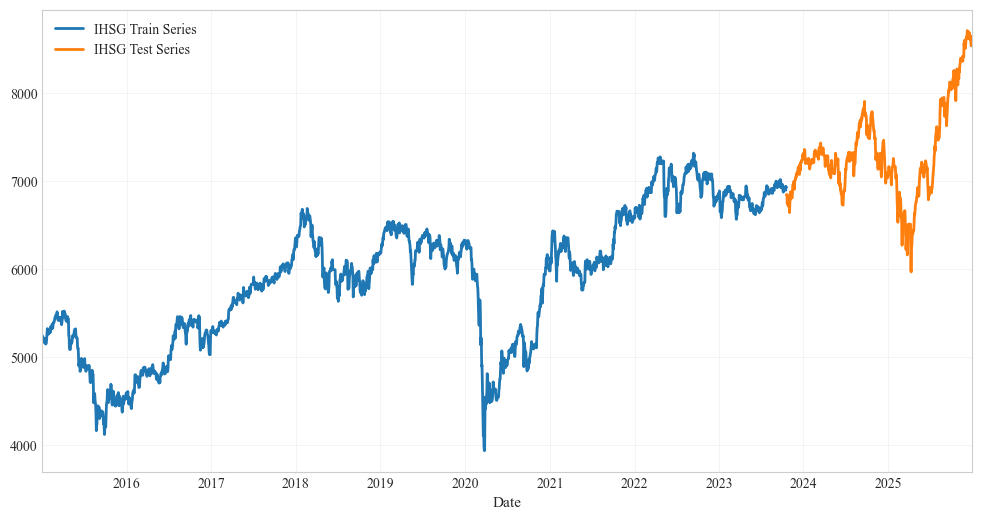

In [18]:
ihsg_train.plot(label='IHSG Train Series')
ihsg_test.plot(label='IHSG Test Series')

In [19]:
IHSG_series_filled

,IHSG
Date,
2015-01-02,5242.769
2015-01-05,5219.995
2015-01-06,5169.060
2015-01-07,5207.118
2015-01-08,5211.828
...,...
2025-12-24,8537.911
2025-12-25,8537.911
2025-12-26,8537.911


In [20]:
print("DARTS TIMESERIES")
print("="*60)
print(f"Target Series (IHSG):")
print(f"  - Start: {IHSG_series_filled.start_time()}")
print(f"  - End: {IHSG_series_filled.end_time()}")
print(f"  - Length: {len(IHSG_series_filled)} time steps")
print(f"  - Frequency: {IHSG_series_filled.freq}")
print(f"\nCovariates:")
print(f"  - Components: {COVAR_series_filled.components.tolist()}")
print(f"  - Length: {len(COVAR_series_filled)} time steps")

DARTS TIMESERIES
Target Series (IHSG):
  - Start: 2015-01-02 00:00:00
  - End: 2025-12-30 00:00:00
  - Length: 2868 time steps
  - Frequency: <BusinessDay>

Covariates:
  - Components: ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']
  - Length: 2868 time steps


In [21]:
from darts.dataprocessing.transformers import Scaler

scaler_ihsg = Scaler(MinMaxScaler(feature_range=(-1, 1)))

ihsg_train_scaled = scaler_ihsg.fit_transform(ihsg_train)
ihsg_test_scaled = scaler_ihsg.transform(ihsg_test)

scaler_covar = Scaler(MinMaxScaler(feature_range=(-1, 1)))

covar_train_scaled = scaler_covar.fit_transform(covar_train)
covar_test_scaled = scaler_covar.transform(covar_test)

covar_full_scaled = covar_train_scaled.append(covar_test_scaled)

# =====================================================
# VERIFIKASI TIDAK ADA LEAKAGE
# =====================================================
print("="*60)
print("DATA LEAKAGE CHECK")
print("="*60)
print(f"Train Target: {ihsg_train_scaled.start_time()} → {ihsg_train_scaled.end_time()}")
print(f"Train Cov:    {covar_train_scaled.start_time()} → {covar_train_scaled.end_time()}")
print(f"Test Target:  {ihsg_test_scaled.start_time()} → {ihsg_test_scaled.end_time()}")
print(f"Test Cov:     {covar_test_scaled.start_time()} → {covar_test_scaled.end_time()}")

# Pastikan train periods match
assert ihsg_train_scaled.end_time() == covar_train_scaled.end_time(), \
    "ERROR: Train target dan covariates tidak sinkron!"
print("\n✓ No data leakage detected in split")

DATA LEAKAGE CHECK
Train Target: 2015-01-02 00:00:00 → 2023-10-18 00:00:00
Train Cov:    2015-01-02 00:00:00 → 2023-10-18 00:00:00
Test Target:  2023-10-19 00:00:00 → 2025-12-30 00:00:00
Test Cov:     2023-10-19 00:00:00 → 2025-12-30 00:00:00

✓ No data leakage detected in split


## 5. Train/Test Split and Scaling

In [22]:
print("DARTS TIMESERIES")
print("="*60)
print(f"Target Series (IHSG):")
print(f"  - Start: {IHSG_series.start_time()}")
print(f"  - End: {IHSG_series.end_time()}")
print(f"  - Length: {len(IHSG_series)} time steps")
print(f"  - Frequency: {IHSG_series.freq}")
print(f"\nCovariates:")
print(f"  - Components: {COVAR_series.components.tolist()}")
print(f"  - Length: {len(COVAR_series)} time steps")

DARTS TIMESERIES
Target Series (IHSG):
  - Start: 2015-01-02 00:00:00
  - End: 2025-12-30 00:00:00
  - Length: 2868 time steps
  - Frequency: <BusinessDay>

Covariates:
  - Components: ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']
  - Length: 2868 time steps


## 6. Hyperparameter Tuning with GridSearch

In [23]:
OUTPUT_CHUNK_LENGTH = 1

# hyperparameter tuning gridsearch

param_grid = {
    'lags': [1, 3, 6, 12],
    'lags_past_covariates': [1, 3, 6, 12],       
    'n_estimators': [50, 100, 200],           
    'max_depth': [3, 5, 7, None],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],        
}
    
print("\nGridSearch Parameters:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to evaluate: {total_combinations}")



GridSearch Parameters:
  lags: [1, 3, 6, 12]
  lags_past_covariates: [1, 3, 6, 12]
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 7, None]
  max_features: [None, 'sqrt', 'log2']
  bootstrap: [True, False]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]

Total combinations to evaluate: 10368


In [24]:
best_model, best_params, best_score = RandomForestModel.gridsearch(
    parameters=param_grid,
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    val_series=ihsg_test_scaled,
    metric=mape,
    verbose=True,
    n_jobs=-1,
    n_random_samples=200
)

print("\n" + "="*60)
print("GRIDSEARCH RESULTS")
print("="*60)
print(f"Best MAPE Score: {best_score:.4f}%")
print(f"\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

gridsearch:   0%|          | 0/200 [00:00<?, ?it/s]


GRIDSEARCH RESULTS
Best MAPE Score: 26.0751%

Best Hyperparameters:
  lags: 1
  lags_past_covariates: 6
  n_estimators: 50
  max_depth: None
  max_features: None
  bootstrap: False
  min_samples_split: 2
  min_samples_leaf: 4


## 7. Train Best Model and Generate Predictions

In [25]:
final_model = RandomForestModel(
    lags=best_params['lags'],
    lags_past_covariates=best_params['lags_past_covariates'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

In [26]:
final_model.fit(
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    verbose=True
)

RandomForestModel(lags=1, lags_past_covariates=6, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, n_estimators=50, max_depth=None, multi_models=True, use_static_covariates=True, random_state=42, max_features=None, bootstrap=False, min_samples_split=2, min_samples_leaf=4, n_jobs=-1)

In [27]:
forecast = final_model.predict(
    n=len(ihsg_test_scaled),
    past_covariates=covar_full_scaled
)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [28]:
from darts.metrics import mape

test_mape = mape(ihsg_test_scaled, forecast)
print(f"Test MAPE: {test_mape:.4f}%")

Test MAPE: 26.0332%


In [29]:
ihsg_full_scaled = ihsg_train_scaled.append(ihsg_test_scaled)

final_model.fit(
    series=ihsg_full_scaled,
    past_covariates=covar_full_scaled,
    verbose=True
)


RandomForestModel(lags=1, lags_past_covariates=6, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, n_estimators=50, max_depth=None, multi_models=True, use_static_covariates=True, random_state=42, max_features=None, bootstrap=False, min_samples_split=2, min_samples_leaf=4, n_jobs=-1)

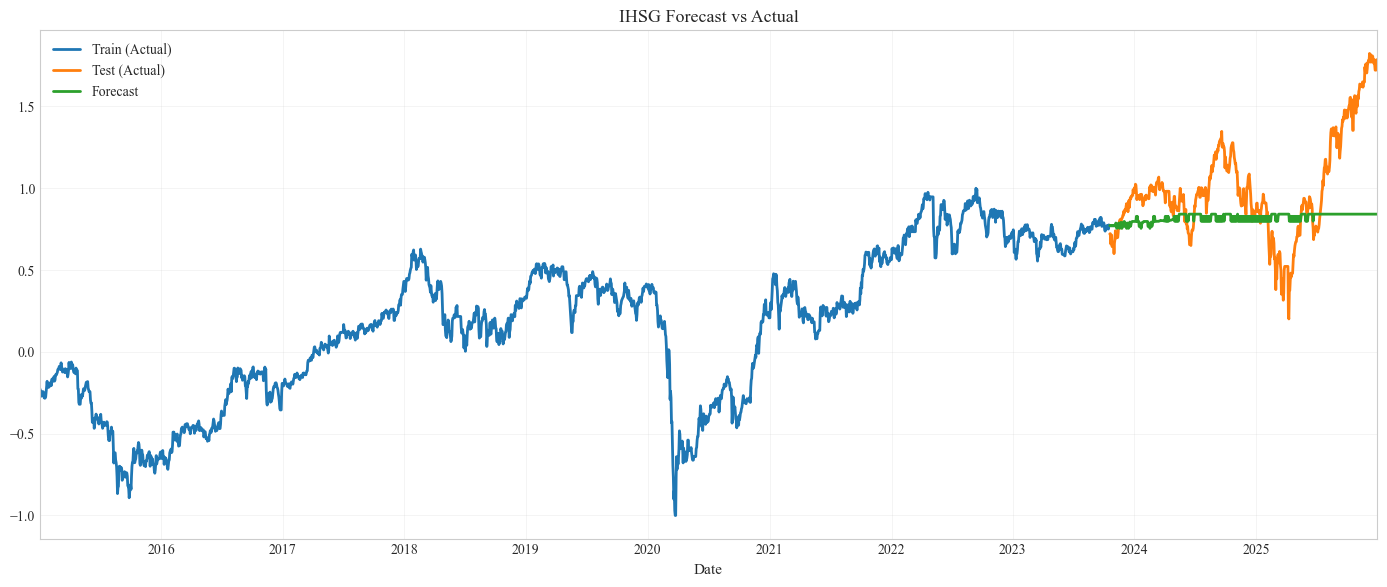

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# actual
ihsg_train_scaled.plot(label="Train (Actual)")
ihsg_test_scaled.plot(label="Test (Actual)")

# forecast
forecast.plot(label="Forecast", linewidth=2)

plt.title("IHSG Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


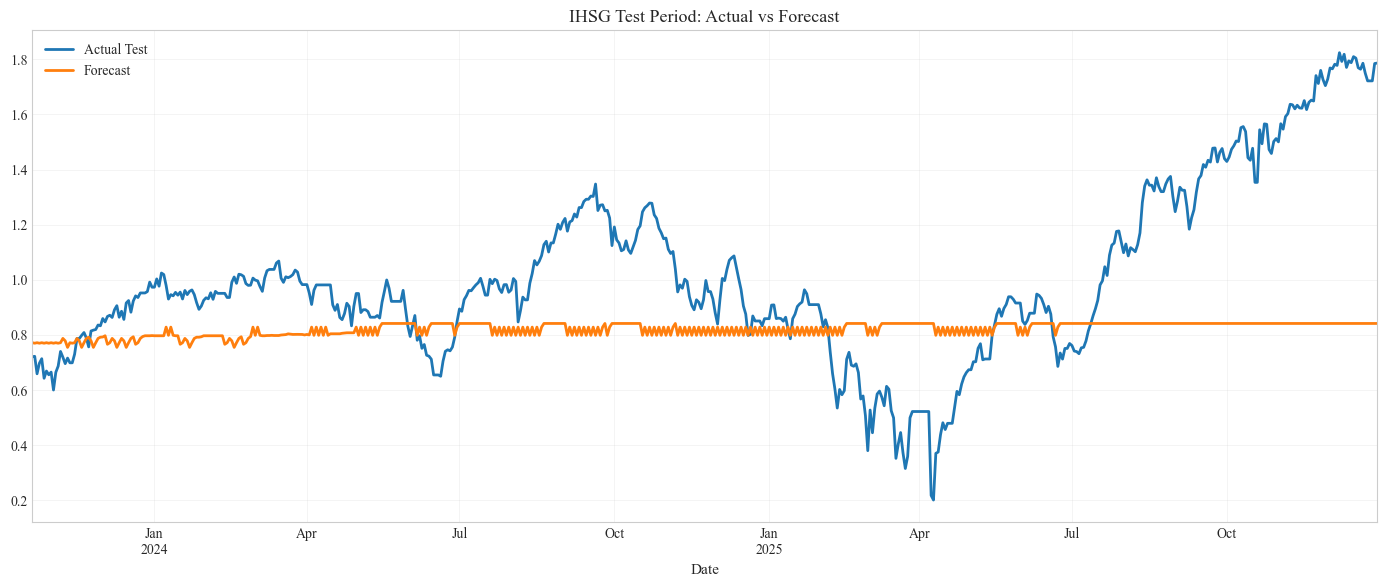

In [31]:
plt.figure(figsize=(14, 6))

ihsg_test_scaled.plot(label="Actual Test")
forecast.plot(label="Forecast", linewidth=2)

plt.title("IHSG Test Period: Actual vs Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# Generate 1-step-ahead predictions using historical_forecasts
# This simulates real-world scenario: predict month t+1, then move forward

predictions_scaled = final_model.historical_forecasts(
    series=ihsg_full_scaled,
    past_covariates=covar_full_scaled,
    start=ihsg_test_scaled.start_time(),
    forecast_horizon=1,  # 1 month ahead
    stride=1,            # Move 1 step each time
    retrain=False,       # Use the trained model without retraining
    verbose=True
)

predictions = scaler_ihsg.inverse_transform(predictions_scaled)
test_actual = scaler_ihsg.inverse_transform(ihsg_test_scaled)

print("="*60)
print("PREDICTIONS GENERATED (1-Step-Ahead)")
print("="*60)
print(f"Prediction Period: {predictions.start_time()} to {predictions.end_time()}")
print(f"Number of predictions: {len(predictions)}")
print(f"Forecast Method: Rolling 1-month-ahead forecast")

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

PREDICTIONS GENERATED (1-Step-Ahead)
Prediction Period: 2023-10-19 00:00:00 to 2025-12-30 00:00:00
Number of predictions: 574
Forecast Method: Rolling 1-month-ahead forecast


In [33]:
# Calculate evaluation metrics
mape_score = mape(test_actual, predictions)
rmse_score = rmse(test_actual, predictions)
mae_score = mae(test_actual, predictions)
r2 = r2_score(test_actual, predictions)

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"MAPE (Mean Absolute Percentage Error): {mape_score:.4f}%")
print(f"RMSE (Root Mean Square Error):         {rmse_score:.4f}")
print(f"MAE (Mean Absolute Error):             {mae_score:.4f}")
print(f"R² Score:                              {r2:.4f}")
print("="*60)

# Interpretation
print("\n📊 INTERPRETATION:")
if mape_score < 5:
    print(f"  ✅ MAPE < 5%: Excellent forecasting accuracy")
elif mape_score < 10:
    print(f"  ✅ MAPE < 10%: Good forecasting accuracy")
elif mape_score < 20:
    print(f"  ⚠️ MAPE < 20%: Reasonable forecasting accuracy")
else:
    print(f"  ❌ MAPE > 20%: Poor forecasting accuracy")

MODEL EVALUATION METRICS
MAPE (Mean Absolute Percentage Error): 0.3756%
RMSE (Root Mean Square Error):         39.5052
MAE (Mean Absolute Error):             26.9559
R² Score:                              0.9944

📊 INTERPRETATION:
  ✅ MAPE < 5%: Excellent forecasting accuracy


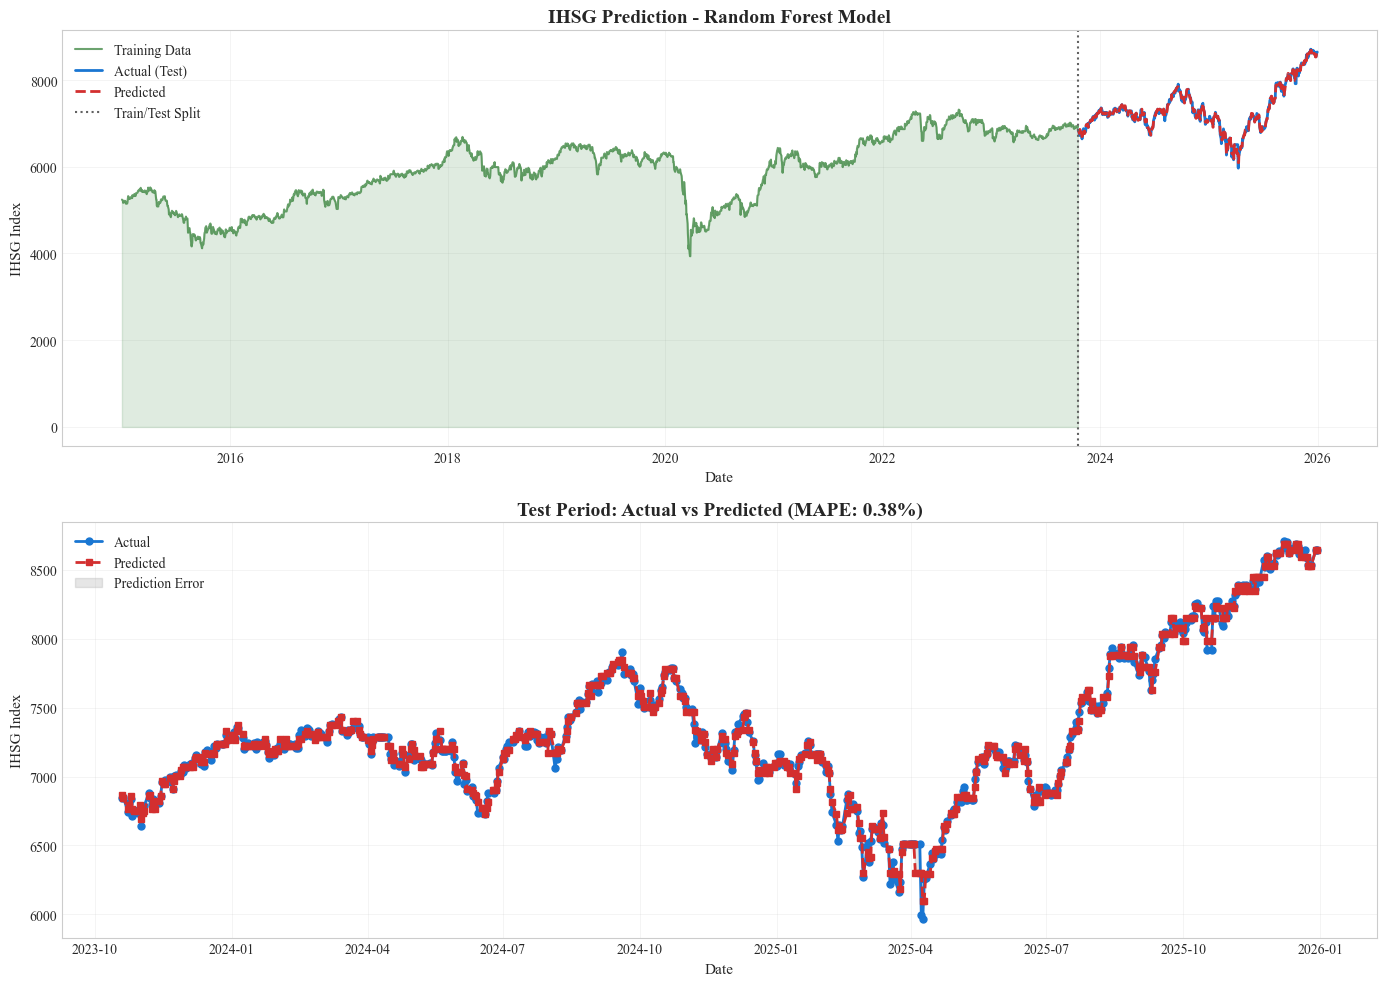

✅ Figure saved: model1-figure/prediction_results.png (300 DPI)


In [34]:
# Visualization: Actual vs Predicted with thesis color palette
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full time series with predictions
ax1 = axes[0]
ax1.plot(ihsg_train.time_index, ihsg_train.values(), 
         label='Training Data', color=COLORS['train'], linewidth=1.5, alpha=0.7)
ax1.plot(test_actual.time_index, test_actual.values(), 
         label='Actual (Test)', color=COLORS['actual'], linewidth=2)
ax1.plot(predictions.time_index, predictions.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=2, linestyle='--')
ax1.axvline(x=ihsg_train.end_time(), color=COLORS['split_line'], linestyle=':', linewidth=1.5, label='Train/Test Split')
ax1.fill_between(ihsg_train.time_index, ihsg_train.values().flatten(), alpha=0.15, color=COLORS['train'])
ax1.set_title('IHSG Prediction - Random Forest Model', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('IHSG Index')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Test period close-up
ax2 = axes[1]
ax2.plot(test_actual.time_index, test_actual.values(), 
         label='Actual', color=COLORS['actual'], linewidth=2, marker='o', markersize=5)
ax2.plot(predictions.time_index, predictions.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=2, linestyle='--', marker='s', markersize=5)
ax2.fill_between(test_actual.time_index, 
                  test_actual.values().flatten(), 
                  predictions.values().flatten(), 
                  alpha=0.25, color=COLORS['error'], label='Prediction Error')
ax2.set_title(f'Test Period: Actual vs Predicted (MAPE: {mape_score:.2f}%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('IHSG Index')
ax2.legend(loc='upper left', framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model1-figure/prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/prediction_results.png (300 DPI)")

In [37]:
COVARIATE_COLS = ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']

rf_estimator = final_model.model.estimators_[0]

# Prepare feature matrix for SHAP
# We need to reconstruct the lagged features that the model uses
lags = best_params['lags']
lags_cov = best_params['lags_past_covariates']

# Create lagged feature dataframe
def create_lagged_features(target_df, cov_df, target_lags, cov_lags):
    """Create lagged features for SHAP analysis"""
    features = pd.DataFrame(index=target_df.index[max(target_lags, cov_lags):])
    
    # Target lags
    for lag in range(1, target_lags + 1):
        features[f'IHSG_lag{lag}'] = target_df['IHSG'].shift(lag).values[max(target_lags, cov_lags):]
    
    # Covariate lags
    for col in cov_df.columns:
        for lag in range(1, cov_lags + 1):
            features[f'{col}_lag{lag}'] = cov_df[col].shift(lag).values[max(target_lags, cov_lags):]
    
    return features.dropna()

# Prepare data
target_df = df.set_index('Date')[['IHSG']]
cov_df = df.set_index('Date')[COVARIATE_COLS]

X_features = create_lagged_features(target_df, cov_df, lags, lags_cov)

print("="*60)
print("FEATURE MATRIX FOR SHAP")
print("="*60)
print(f"Feature matrix shape: {X_features.shape}")
print(f"\nFeatures ({len(X_features.columns)}):")
for i, col in enumerate(X_features.columns, 1):
    print(f"  {i}. {col}")

FEATURE MATRIX FOR SHAP
Feature matrix shape: (2558, 43)

Features (43):
  1. IHSG_lag1
  2. STI_lag1
  3. STI_lag2
  4. STI_lag3
  5. STI_lag4
  6. STI_lag5
  7. STI_lag6
  8. Gold_lag1
  9. Gold_lag2
  10. Gold_lag3
  11. Gold_lag4
  12. Gold_lag5
  13. Gold_lag6
  14. Coal_lag1
  15. Coal_lag2
  16. Coal_lag3
  17. Coal_lag4
  18. Coal_lag5
  19. Coal_lag6
  20. Copper_lag1
  21. Copper_lag2
  22. Copper_lag3
  23. Copper_lag4
  24. Copper_lag5
  25. Copper_lag6
  26. Silver_lag1
  27. Silver_lag2
  28. Silver_lag3
  29. Silver_lag4
  30. Silver_lag5
  31. Silver_lag6
  32. Tin_lag1
  33. Tin_lag2
  34. Tin_lag3
  35. Tin_lag4
  36. Tin_lag5
  37. Tin_lag6
  38. Nickel_lag1
  39. Nickel_lag2
  40. Nickel_lag3
  41. Nickel_lag4
  42. Nickel_lag5
  43. Nickel_lag6


In [38]:
# Train a standalone RandomForest model for SHAP analysis
from sklearn.ensemble import RandomForestRegressor

# Prepare target (shifted to align with features)
y_target = target_df['IHSG'].values[max(lags, lags_cov) + 1:]  # +1 for next month prediction
X_train = X_features.iloc[:-1].values  # Remove last row to match y_target length

# Ensure alignment
min_len = min(len(X_train), len(y_target))
X_train = X_train[:min_len]
y_target = y_target[:min_len]

# Train RF model for SHAP
rf_shap = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42,
    n_jobs=-1
)
rf_shap.fit(X_train, y_target)

print("="*60)
print("RANDOM FOREST FOR SHAP ANALYSIS")
print("="*60)
print(f"Model fitted on {X_train.shape[0]} samples with {X_train.shape[1]} features")
print(f"R² Score: {rf_shap.score(X_train, y_target):.4f}")

RANDOM FOREST FOR SHAP ANALYSIS
Model fitted on 2557 samples with 43 features
R² Score: 0.9991


In [39]:
# SHAP Analysis
print("="*60)
print("COMPUTING SHAP VALUES (this may take a moment...)")
print("="*60)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_shap)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Create DataFrame with feature names
X_train_df = pd.DataFrame(X_train, columns=X_features.columns[:-1] if len(X_features.columns) > X_train.shape[1] else X_features.columns[:X_train.shape[1]])

print("✅ SHAP values computed successfully!")

COMPUTING SHAP VALUES (this may take a moment...)
✅ SHAP values computed successfully!


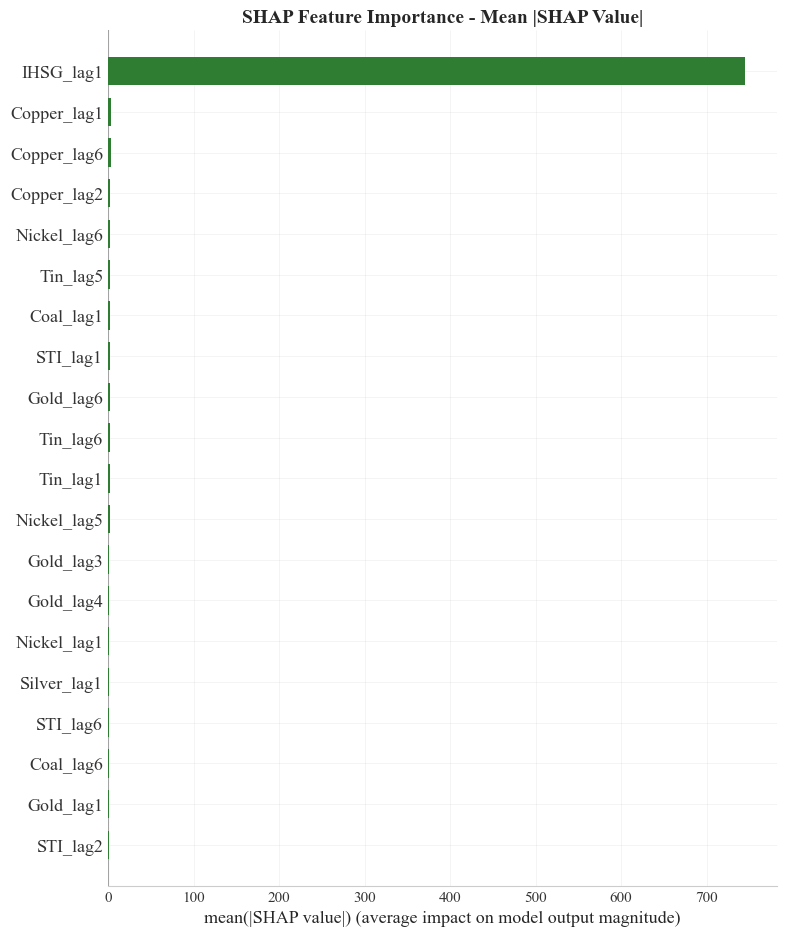

✅ Figure saved: model1-figure/shap_importance_bar.png (300 DPI)


In [40]:
# SHAP Summary Plot (Bar)
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_df, plot_type="bar", show=False, color=COLORS['IHSG'])
plt.title('SHAP Feature Importance - Mean |SHAP Value|', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model1-figure/shap_importance_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/shap_importance_bar.png (300 DPI)")

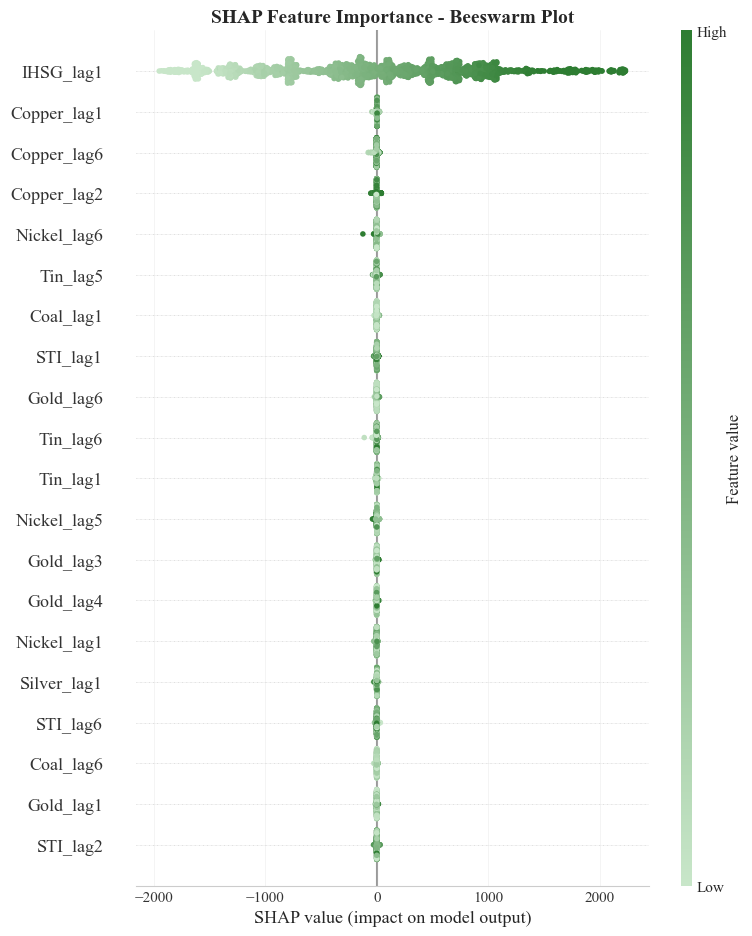

✅ Figure saved: model1-figure/shap_importance_beeswarm.png (300 DPI)


In [41]:
# SHAP Summary Plot (Beeswarm) with custom colormap
fig, ax = plt.subplots(figsize=(12, 10))

# Custom colormap for SHAP beeswarm (Green gradient)
from matplotlib.colors import LinearSegmentedColormap
shap_cmap = LinearSegmentedColormap.from_list('shap_green', ['#C8E6C9', '#2E7D32'], N=256)

shap.summary_plot(shap_values, X_train_df, show=False, cmap=shap_cmap)
plt.title('SHAP Feature Importance - Beeswarm Plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model1-figure/shap_importance_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/shap_importance_beeswarm.png (300 DPI)")

In [42]:
# Calculate aggregated feature importance by variable (not by lag)
feature_importance_by_var = {}

for col in X_train_df.columns:
    # Extract variable name (remove lag suffix)
    if '_lag' in col:
        var_name = col.rsplit('_lag', 1)[0]
    else:
        var_name = col
    
    col_idx = list(X_train_df.columns).index(col)
    importance = np.abs(shap_values[:, col_idx]).mean()
    
    if var_name not in feature_importance_by_var:
        feature_importance_by_var[var_name] = 0
    feature_importance_by_var[var_name] += importance

# Sort by importance
sorted_importance = dict(sorted(feature_importance_by_var.items(), key=lambda x: x[1], reverse=True))

print("="*60)
print("AGGREGATED FEATURE IMPORTANCE BY VARIABLE")
print("="*60)
total_importance = sum(sorted_importance.values())
for var, importance in sorted_importance.items():
    pct = (importance / total_importance) * 100
    bar = "█" * int(pct / 2)
    print(f"{var:15} : {importance:8.4f} ({pct:5.2f}%) {bar}")

AGGREGATED FEATURE IMPORTANCE BY VARIABLE
IHSG            : 745.0543 (92.36%) ██████████████████████████████████████████████
Copper          :  12.0476 ( 1.49%) 
Tin             :   9.4627 ( 1.17%) 
Nickel          :   8.7219 ( 1.08%) 
Gold            :   8.6604 ( 1.07%) 
STI             :   8.3685 ( 1.04%) 
Coal            :   7.7165 ( 0.96%) 
Silver          :   6.6494 ( 0.82%) 


KeyError: 'M2_YoY'

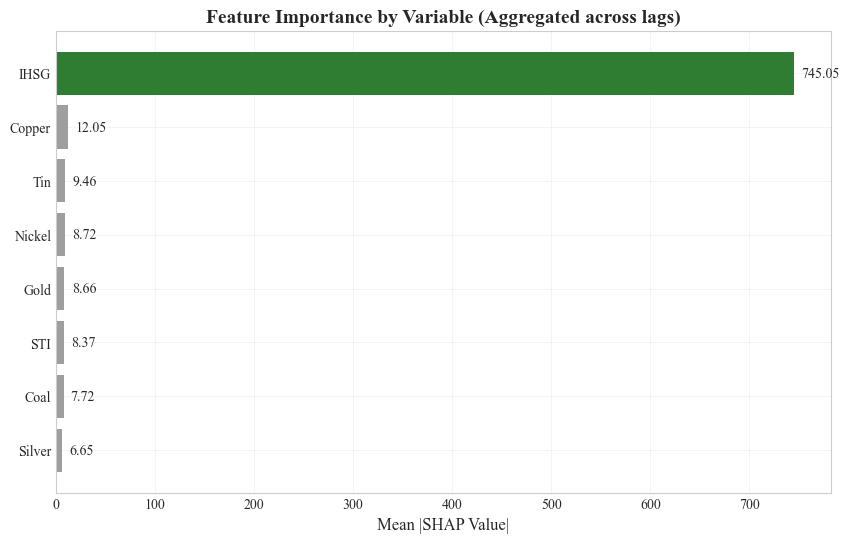

In [43]:
# Visualization: Aggregated Feature Importance with thesis colors
fig, ax = plt.subplots(figsize=(10, 6))

vars_names = list(sorted_importance.keys())
importances = list(sorted_importance.values())

# Color coding: IHSG = Green (primary), Macroeconomic = use palette
bar_colors = []
for v in vars_names:
    if 'IHSG' in v:
        bar_colors.append(COLORS['IHSG'])
    elif 'Inflation' in v:
        bar_colors.append(COLORS['Inflation'])
    elif 'M2' in v:
        bar_colors.append(COLORS['M2_YoY'])
    elif 'USDIDR' in v:
        bar_colors.append(COLORS['USDIDR'])
    elif 'BI_Rate' in v:
        bar_colors.append(COLORS['BI_Rate'])
    elif 'NPL' in v:
        bar_colors.append(COLORS['NPL_Ratio'])
    else:
        bar_colors.append(COLORS['error'])

bars = ax.barh(vars_names[::-1], importances[::-1], color=bar_colors[::-1])
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance by Variable (Aggregated across lags)', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, importances[::-1]):
    ax.text(val + max(importances)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['IHSG'], label='Target (IHSG)'),
    Patch(facecolor=COLORS['M2_YoY'], label='Macroeconomic Variables')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

plt.tight_layout()
plt.savefig('model1-figure/feature_importance_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/feature_importance_aggregated.png (300 DPI)")

## 8. Generate Predictions (1-Step-Ahead)

In [ ]:
# =========================================================================
# GENERATE 1-STEP-AHEAD PREDICTIONS
# =========================================================================
# Using historical_forecasts for rolling 1-step-ahead prediction
# This simulates real-world scenario: predict day t+1, then move forward

predictions_scaled = final_model.historical_forecasts(
    series=target_scaled,
    past_covariates=cov_scaled,
    start=test_target_scaled.start_time(),
    forecast_horizon=1,  # 1 day ahead
    retrain=False,       # Use the trained model without retraining
    verbose=True
)

# Inverse transform to original scale
predictions = scaler_target.inverse_transform(predictions_scaled)
test_actual = scaler_target.inverse_transform(test_target_scaled)

print("="*60)
print("PREDICTIONS GENERATED (1-Step-Ahead)")
print("="*60)
print(f"Prediction Period: {predictions.start_time()} to {predictions.end_time()}")
print(f"Number of predictions: {len(predictions)} trading days")
print(f"Forecast Method: Rolling 1-day-ahead forecast")
print(f"\nCovariates Used:")
print(f"  - Past: {covariates.components.tolist()}")

## 9. Model Evaluation

In [ ]:
# =========================================================================
# MODEL EVALUATION METRICS
# =========================================================================
mape_score = mape(test_actual, predictions)
rmse_score = rmse(test_actual, predictions)
mae_score = mae(test_actual, predictions)
r2 = r2_score(test_actual, predictions)

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"MAPE (Mean Absolute Percentage Error): {mape_score:.4f}%")
print(f"RMSE (Root Mean Square Error):         {rmse_score:.4f}")
print(f"MAE (Mean Absolute Error):             {mae_score:.4f}")
print(f"R² Score:                              {r2:.4f}")
print("="*60)

# Interpretation
print("\nINTERPRETATION:")
if mape_score < 5:
    print(f"  MAPE < 5%: Excellent forecasting accuracy")
elif mape_score < 10:
    print(f"  MAPE < 10%: Good forecasting accuracy")
elif mape_score < 20:
    print(f"  MAPE < 20%: Reasonable forecasting accuracy")
else:
    print(f"  MAPE > 20%: Poor forecasting accuracy")

MODEL EVALUATION METRICS
MAPE (Mean Absolute Percentage Error): 3.5163%
RMSE (Root Mean Square Error):         469.6613
MAE (Mean Absolute Error):             277.6839
R² Score:                              0.1805

INTERPRETATION:
  MAPE < 5%: Excellent forecasting accuracy


Aligned data points: test_actual=570, predictions=570


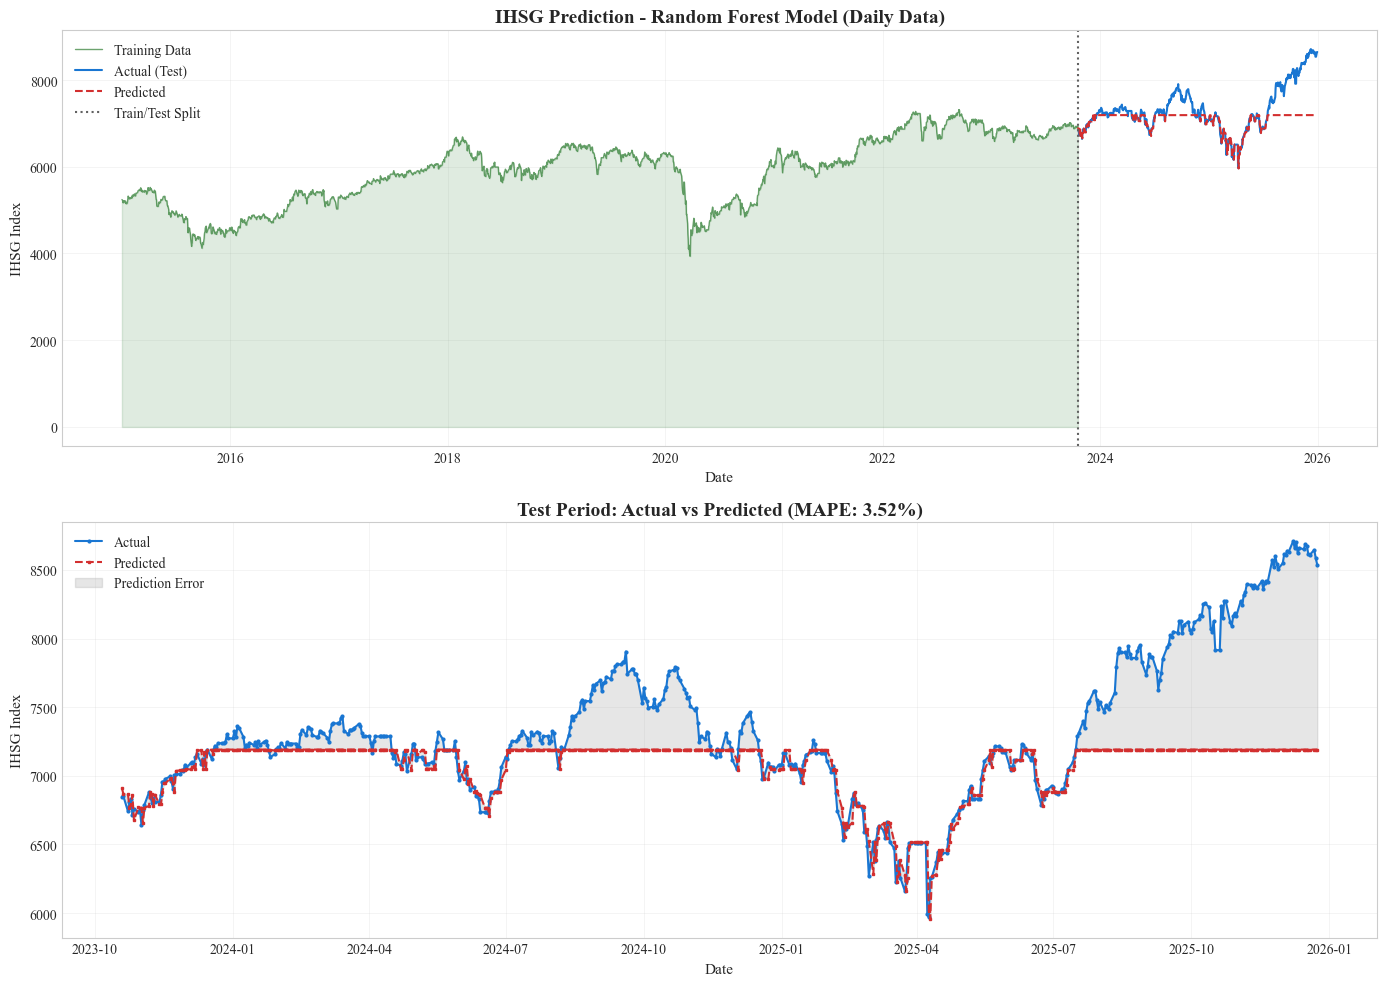

Figure saved: model2_prediction_results.png (300 DPI)


In [ ]:
# =========================================================================
# VISUALIZATION: ACTUAL VS PREDICTED
# =========================================================================

# Align test_actual with predictions time index (predictions may start later due to lags)
test_actual_aligned = test_actual.slice_intersect(predictions)
pred_aligned = predictions.slice_intersect(test_actual)

print(f"Aligned data points: test_actual={len(test_actual_aligned)}, predictions={len(pred_aligned)}")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full time series with predictions
ax1 = axes[0]
ax1.plot(train_target.time_index, train_target.values(), 
         label='Training Data', color=COLORS['train'], linewidth=1, alpha=0.7)
ax1.plot(test_actual.time_index, test_actual.values(), 
         label='Actual (Test)', color=COLORS['actual'], linewidth=1.5)
ax1.plot(predictions.time_index, predictions.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=1.5, linestyle='--')
ax1.axvline(x=train_target.end_time(), color=COLORS['split_line'], linestyle=':', linewidth=1.5, label='Train/Test Split')
ax1.fill_between(train_target.time_index, train_target.values().flatten(), alpha=0.15, color=COLORS['train'])
ax1.set_title('IHSG Prediction - Random Forest Model (Daily Data)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('IHSG Index')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Test period close-up (using aligned data)
ax2 = axes[1]
ax2.plot(test_actual_aligned.time_index, test_actual_aligned.values(), 
         label='Actual', color=COLORS['actual'], linewidth=1.5, marker='o', markersize=2)
ax2.plot(pred_aligned.time_index, pred_aligned.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=1.5, linestyle='--', marker='s', markersize=2)
ax2.fill_between(test_actual_aligned.time_index, 
                  test_actual_aligned.values().flatten(), 
                  pred_aligned.values().flatten(), 
                  alpha=0.25, color=COLORS['error'], label='Prediction Error')
ax2.set_title(f'Test Period: Actual vs Predicted (MAPE: {mape_score:.2f}%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('IHSG Index')
ax2.legend(loc='upper left', framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model2-figure/model2_prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_prediction_results.png (300 DPI)")

## 10. Feature Importance with SHAP

In [ ]:
# Prepare feature matrix for SHAP
lags = best_params['lags']
lags_cov = best_params['lags_past_covariates']

# Create lagged feature dataframe
def create_lagged_features(target_df, cov_df, target_lags, cov_lags):
    """Create lagged features for SHAP analysis"""
    max_lag = max(target_lags, cov_lags)
    features = pd.DataFrame(index=target_df.index[max_lag:])
    
    # Target lags
    for lag in range(1, target_lags + 1):
        features[f'IHSG_lag{lag}'] = target_df['IHSG'].shift(lag).values[max_lag:]
    
    # Covariate lags
    for col in cov_df.columns:
        for lag in range(1, cov_lags + 1):
            features[f'{col}_lag{lag}'] = cov_df[col].shift(lag).values[max_lag:]
    
    return features.dropna()

# Prepare data
target_df = df.set_index('Date')[['IHSG']]
cov_df = df.set_index('Date')[COVARIATE_COLS]

X_features = create_lagged_features(target_df, cov_df, lags, lags_cov)

print("="*60)
print("FEATURE MATRIX FOR SHAP")
print("="*60)
print(f"Feature matrix shape: {X_features.shape}")
print(f"\nFeatures ({len(X_features.columns)}):")
for i, col in enumerate(X_features.columns, 1):
    print(f"  {i}. {col}")

FEATURE MATRIX FOR SHAP
Feature matrix shape: (2543, 51)

Features (51):
  1. IHSG_lag1
  2. IHSG_lag2
  3. IHSG_lag3
  4. IHSG_lag4
  5. IHSG_lag5
  6. IHSG_lag6
  7. IHSG_lag7
  8. IHSG_lag8
  9. IHSG_lag9
  10. IHSG_lag10
  11. IHSG_lag11
  12. IHSG_lag12
  13. IHSG_lag13
  14. IHSG_lag14
  15. IHSG_lag15
  16. IHSG_lag16
  17. IHSG_lag17
  18. IHSG_lag18
  19. IHSG_lag19
  20. IHSG_lag20
  21. IHSG_lag21
  22. STI_lag1
  23. STI_lag2
  24. STI_lag3
  25. STI_lag4
  26. STI_lag5
  27. Coal_lag1
  28. Coal_lag2
  29. Coal_lag3
  30. Coal_lag4
  31. Coal_lag5
  32. Copper_lag1
  33. Copper_lag2
  34. Copper_lag3
  35. Copper_lag4
  36. Copper_lag5
  37. Silver_lag1
  38. Silver_lag2
  39. Silver_lag3
  40. Silver_lag4
  41. Silver_lag5
  42. Tin_lag1
  43. Tin_lag2
  44. Tin_lag3
  45. Tin_lag4
  46. Tin_lag5
  47. Nickel_lag1
  48. Nickel_lag2
  49. Nickel_lag3
  50. Nickel_lag4
  51. Nickel_lag5


In [ ]:
# Train a standalone RandomForest model for SHAP analysis

# Prepare target (shifted to align with features)
max_lag = max(lags, lags_cov)
y_target = target_df['IHSG'].values[max_lag + 1:]  # +1 for next day prediction
X_train_shap = X_features.iloc[:-1].values  # Remove last row to match y_target length

# Ensure alignment
min_len = min(len(X_train_shap), len(y_target))
X_train_shap = X_train_shap[:min_len]
y_target = y_target[:min_len]

# Train RF model for SHAP
rf_shap = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42,
    n_jobs=-1
)
rf_shap.fit(X_train_shap, y_target)

print("="*60)
print("RANDOM FOREST FOR SHAP ANALYSIS")
print("="*60)
print(f"Model fitted on {X_train_shap.shape[0]} samples with {X_train_shap.shape[1]} features")
print(f"R² Score: {rf_shap.score(X_train_shap, y_target):.4f}")

RANDOM FOREST FOR SHAP ANALYSIS
Model fitted on 2542 samples with 51 features
R² Score: 0.9936


In [ ]:
# SHAP Analysis
print("="*60)
print("COMPUTING SHAP VALUES (this may take a moment...)")
print("="*60)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_shap)

# Use a sample for SHAP (full dataset can be slow for daily data)
sample_size = min(1000, len(X_train_shap))
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_shap), sample_size, replace=False)
X_sample = X_train_shap[sample_idx]

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Create DataFrame with feature names
feature_names = X_features.columns[:X_train_shap.shape[1]].tolist()
X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

print(f"✅ SHAP values computed on {sample_size} samples!")

COMPUTING SHAP VALUES (this may take a moment...)
✅ SHAP values computed on 1000 samples!


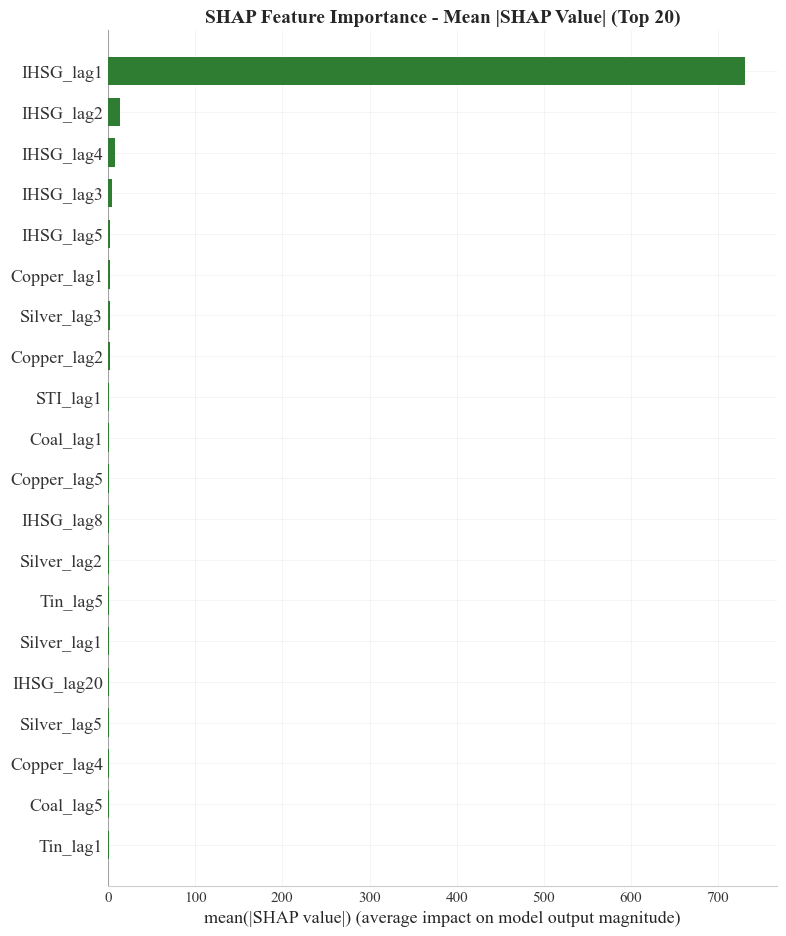

Figure saved: model2_shap_importance_bar.png (300 DPI)


In [ ]:
# SHAP Summary Plot (Bar) with thesis color
fig, ax = plt.subplots(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample_df, plot_type="bar", show=False, max_display=20, color=COLORS['IHSG'])
plt.title('SHAP Feature Importance - Mean |SHAP Value| (Top 20)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model2-figure/model2_shap_importance_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_shap_importance_bar.png (300 DPI)")

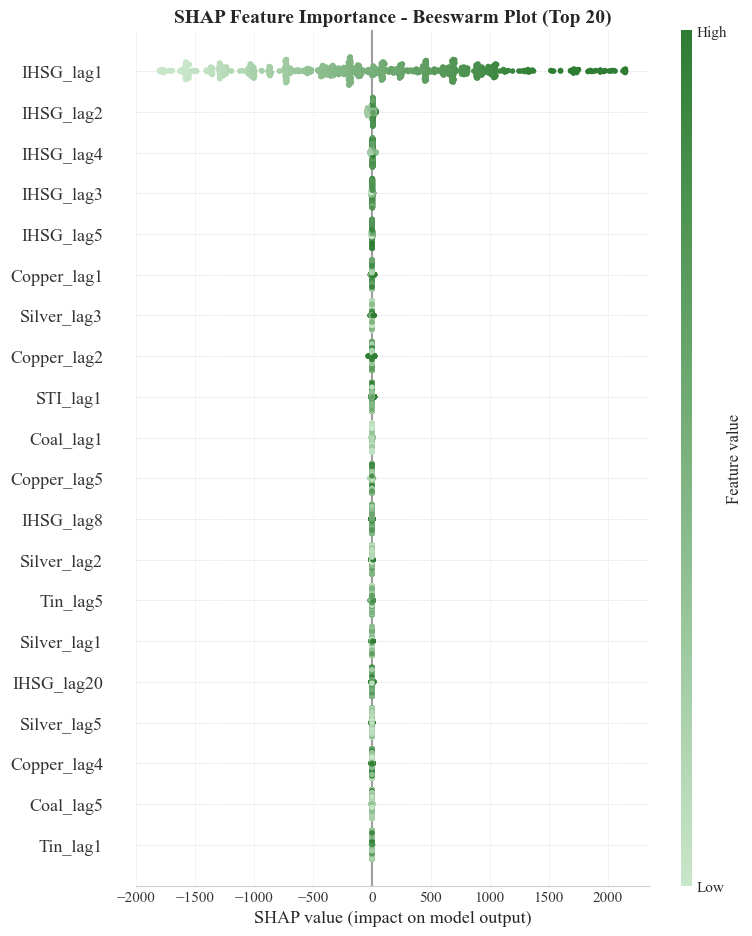

Figure saved: model2_shap_importance_beeswarm.png (300 DPI)


In [ ]:
# SHAP Summary Plot (Beeswarm) with custom colormap
fig, ax = plt.subplots(figsize=(12, 12))

# Custom colormap for SHAP beeswarm (Green gradient)
from matplotlib.colors import LinearSegmentedColormap
shap_cmap = LinearSegmentedColormap.from_list('shap_green', ['#C8E6C9', '#2E7D32'], N=256)

shap.summary_plot(shap_values, X_sample_df, show=False, max_display=20, cmap=shap_cmap)
plt.title('SHAP Feature Importance - Beeswarm Plot (Top 20)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model2-figure/model2_shap_importance_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_shap_importance_beeswarm.png (300 DPI)")

In [ ]:
# Calculate aggregated feature importance by variable (not by lag)
feature_importance_by_var = {}

for col in X_sample_df.columns:
    # Extract variable name (remove lag suffix)
    if '_lag' in col:
        var_name = col.rsplit('_lag', 1)[0]
    else:
        var_name = col
    
    col_idx = list(X_sample_df.columns).index(col)
    importance = np.abs(shap_values[:, col_idx]).mean()
    
    if var_name not in feature_importance_by_var:
        feature_importance_by_var[var_name] = 0
    feature_importance_by_var[var_name] += importance

# Sort by importance
sorted_importance = dict(sorted(feature_importance_by_var.items(), key=lambda x: x[1], reverse=True))

print("="*60)
print("AGGREGATED FEATURE IMPORTANCE BY VARIABLE")
print("="*60)
total_importance = sum(sorted_importance.values())
for var, importance in sorted_importance.items():
    pct = (importance / total_importance) * 100
    bar = "█" * int(pct / 2)
    print(f"{var:15} : {importance:8.4f} ({pct:5.2f}%) {bar}")

AGGREGATED FEATURE IMPORTANCE BY VARIABLE
IHSG            : 764.0240 (97.91%) ████████████████████████████████████████████████
Copper          :   4.9310 ( 0.63%) 
Silver          :   4.3382 ( 0.56%) 
Coal            :   2.3436 ( 0.30%) 
Tin             :   2.0164 ( 0.26%) 
STI             :   1.5788 ( 0.20%) 
Nickel          :   1.1113 ( 0.14%) 


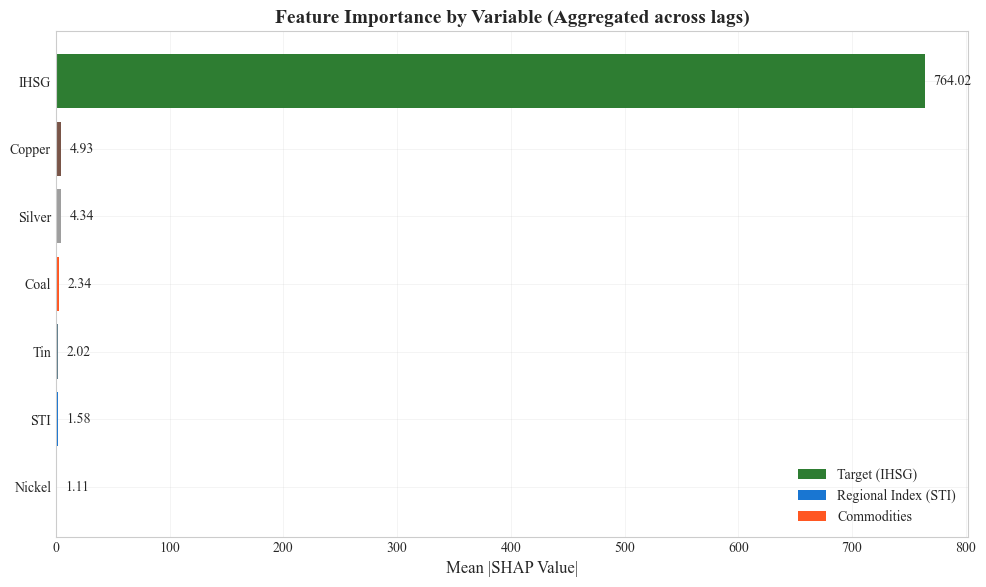

Figure saved: model2_feature_importance_aggregated.png (300 DPI)


In [ ]:
# =========================================================================
# VISUALIZATION: AGGREGATED FEATURE IMPORTANCE
# =========================================================================
fig, ax = plt.subplots(figsize=(10, 6))

vars_names = list(sorted_importance.keys())
importances = list(sorted_importance.values())

# Color coding with thesis palette
bar_colors = []
for v in vars_names:
    if 'IHSG' in v:
        bar_colors.append(COLORS['IHSG'])
    elif 'STI' in v:
        bar_colors.append(COLORS['STI'])
    elif 'Coal' in v:
        bar_colors.append(COLORS['Coal'])
    elif 'Copper' in v:
        bar_colors.append(COLORS['Copper'])
    elif 'Silver' in v:
        bar_colors.append(COLORS['Silver'])
    elif 'Tin' in v:
        bar_colors.append(COLORS['Tin'])
    elif 'Nickel' in v:
        bar_colors.append(COLORS['Nickel'])
    else:
        bar_colors.append(COLORS['error'])

bars = ax.barh(vars_names[::-1], importances[::-1], color=bar_colors[::-1])
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance by Variable (Aggregated across lags)', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, importances[::-1]):
    ax.text(val + max(importances)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['IHSG'], label='Target (IHSG)'),
    Patch(facecolor=COLORS['STI'], label='Regional Index (STI)'),
    Patch(facecolor=COLORS['Coal'], label='Commodities')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

plt.tight_layout()
plt.savefig('model2-figure/model2_feature_importance_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_feature_importance_aggregated.png (300 DPI)")

## 11. Results Summary

In [ ]:
# =========================================================================
# FINAL SUMMARY
# =========================================================================
print("="*70)
print("HASIL PENELITIAN MODEL 2: IHSG DENGAN KOMODITAS DAN STI (DAILY)")
print("="*70)

print("\nDATA:")
print(f"   - Periode Data     : {df['Date'].min().strftime('%d %B %Y')} - {df['Date'].max().strftime('%d %B %Y')}")
print(f"   - Total Observasi  : {len(df)} hari trading")
print(f"   - Train/Test Split : {TRAIN_RATIO*100:.0f}% / {(1-TRAIN_RATIO)*100:.0f}%")

print("\nTARGET:")
print(f"   - Variabel Target  : IHSG (Indeks Harga Saham Gabungan) - Daily")

print("\nCOVARIATES:")
print("   Regional Index:")
print("     1. STI (Straits Times Index)")
print("   Commodities:")
for i, col in enumerate(['Coal', 'Copper', 'Silver', 'Tin', 'Nickel'], 2):
    print(f"     {i}. {col}")

print("\nBEST HYPERPARAMETERS:")
for param, value in best_params.items():
    print(f"   - {param}: {value}")

print("\nMODEL PERFORMANCE (Random Forest):")
print(f"   - MAPE  : {mape_score:.4f}%")
print(f"   - RMSE  : {rmse_score:.4f}")
print(f"   - MAE   : {mae_score:.4f}")
print(f"   - R2    : {r2:.4f}")

print("\nFEATURE IMPORTANCE (SHAP - Top 3):")
for i, (var, imp) in enumerate(list(sorted_importance.items())[:3], 1):
    pct = (imp / total_importance) * 100
    print(f"   {i}. {var}: {pct:.2f}%")

print("\n" + "="*70)
print("Source: Author's calculation, 2025")
print("="*70)

In [ ]:
# =========================================================================
# SAVE RESULTS
# =========================================================================
results_df = pd.DataFrame({
    'Date': test_actual.time_index,
    'Actual_IHSG': test_actual.values().flatten(),
    'Predicted_IHSG': predictions.values().flatten(),
    'Error': (predictions.values().flatten() - test_actual.values().flatten()),
    'APE_%': np.abs((predictions.values().flatten() - test_actual.values().flatten()) / test_actual.values().flatten()) * 100
})

results_df.to_csv('model2_predictions.csv', index=False)
print("Predictions saved to 'model2_predictions.csv'")

# Also save the merged dataset
df.to_csv('model2_merged_data.csv', index=False)
print("Merged dataset saved to 'model2_merged_data.csv'")

# Display prediction results
print("\nPrediction Results (first 10 rows):")
results_df.head(10).round(2)

ValueError: operands could not be broadcast together with shapes (570,) (574,) 

## 12. Benchmark: XGBoost Model

In [ ]:
# =========================================================================
# XGBOOST HYPERPARAMETER TUNING
# =========================================================================
from darts.models import XGBModel

print("="*60)
print("XGBOOST HYPERPARAMETER TUNING WITH OPTUNA")
print("="*60)
print(f"\nForecast Horizon: {OUTPUT_CHUNK_LENGTH} day(s) ahead")
print("\nSearch Space:")
print("  [Darts Parameters]")
print("  lags: [5, 10, 21, 42] (categorical)")
print("  lags_past_covariates: [5, 10, 21, 42] (categorical)")
print("\n  [XGBoost Parameters]")
print("  n_estimators: [100, 200, 300] (categorical)")
print("  max_depth: [3, 5, 7, 10] (categorical)")
print("  learning_rate: [0.01, 0.05, 0.1, 0.2] (categorical)")
print("  subsample: [0.6, 0.8, 1.0] (categorical)")
print("  colsample_bytree: [0.6, 0.8, 1.0] (categorical)")

XGBOOST HYPERPARAMETER TUNING WITH OPTUNA

Forecast Horizon: 1 day(s) ahead

Search Space:
  [Darts Parameters]
  lags: [5, 10, 21, 42] (categorical)
  lags_past_covariates: [5, 10, 21, 42] (categorical)

  [XGBoost Parameters]
  n_estimators: [100, 200, 300] (categorical)
  max_depth: [3, 5, 7, 10] (categorical)
  learning_rate: [0.01, 0.05, 0.1, 0.2] (categorical)
  subsample: [0.6, 0.8, 1.0] (categorical)
  colsample_bytree: [0.6, 0.8, 1.0] (categorical)


In [ ]:
# =========================================================================
# XGBOOST OPTUNA OPTIMIZATION
# =========================================================================
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.WARNING)

def xgb_objective(trial):
    """Objective function for XGBoost Optuna optimization"""
    
    # Darts parameters
    lags = trial.suggest_categorical('lags', [5, 10, 21, 42])
    lags_past_covariates = trial.suggest_categorical('lags_past_covariates', [5, 10, 21, 42])
    
    # XGBoost specific parameters
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10])
    learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2])
    subsample = trial.suggest_categorical('subsample', [0.6, 0.8, 1.0])
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0])
    
    try:
        model = XGBModel(
            lags=lags,
            lags_past_covariates=lags_past_covariates,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
            verbosity=0
        )
        
        model.fit(
            train_target_scaled, 
            past_covariates=cov_scaled
        )
        
        backtest_pred = model.historical_forecasts(
            series=target_scaled,
            past_covariates=cov_scaled,
            start=test_target_scaled.start_time(),
            forecast_horizon=1,
            retrain=False,
            verbose=False
        )
        
        mape_score = mape(test_target_scaled, backtest_pred)
        return mape_score
        
    except Exception as e:
        return float('inf')

def xgb_print_callback(study, trial):
    if trial.number % 10 == 0:
        print(f"  Trial {trial.number}: MAPE = {trial.value:.4f}% | Best so far: {study.best_value:.4f}%")

print("="*60)
print("RUNNING XGBOOST OPTUNA OPTIMIZATION")
print("="*60)

XGB_N_TRIALS = 100
total_xgb_combinations = 4 * 4 * 3 * 4 * 4 * 3 * 3
print(f"\nTotal possible combinations: {total_xgb_combinations}")
print(f"Number of trials: {XGB_N_TRIALS} ({XGB_N_TRIALS/total_xgb_combinations*100:.1f}% of search space)")
print(f"Forecast horizon: {OUTPUT_CHUNK_LENGTH} day (1-step-ahead)")
print(f"\nCovariates:")
print(f"  - Past: {covariates.components.tolist()}")
print("\nProgress (every 10 trials):")

xgb_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42)
)

xgb_study.optimize(
    xgb_objective, 
    n_trials=XGB_N_TRIALS, 
    callbacks=[xgb_print_callback],
    show_progress_bar=True
)

xgb_best_params = xgb_study.best_trial.params.copy()
xgb_best_params['output_chunk_length'] = OUTPUT_CHUNK_LENGTH
xgb_best_score = xgb_study.best_value

print("\n" + "="*60)
print("XGBOOST OPTUNA RESULTS")
print("="*60)
print(f"Best MAPE Score: {xgb_best_score:.4f}%")
print(f"Total Trials: {len(xgb_study.trials)}")
print(f"\nBest Hyperparameters:")
for param, value in xgb_best_params.items():
    print(f"  {param}: {value}")

print("\n" + "="*60)
print("TOP 5 TRIALS")
print("="*60)
xgb_trials_df = xgb_study.trials_dataframe()
xgb_trials_df = xgb_trials_df.sort_values('value').head(5)
for idx, row in xgb_trials_df.iterrows():
    print(f"  Trial {row['number']}: MAPE = {row['value']:.4f}%")

In [ ]:
# =========================================================================
# TRAIN FINAL XGBOOST MODEL
# =========================================================================
print("\n" + "="*60)
print("TRAINING FINAL XGBOOST MODEL")
print("="*60)

xgb_final_model = XGBModel(
    lags=xgb_best_params['lags'],
    lags_past_covariates=xgb_best_params['lags_past_covariates'],
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    n_estimators=xgb_best_params['n_estimators'],
    max_depth=xgb_best_params['max_depth'],
    learning_rate=xgb_best_params['learning_rate'],
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    random_state=42,
    verbosity=0
)

xgb_final_model.fit(
    train_target_scaled, 
    past_covariates=cov_scaled
)
print("XGBoost model trained successfully!")

In [ ]:
# =========================================================================
# XGBOOST PREDICTIONS & EVALUATION
# =========================================================================
xgb_predictions_scaled = xgb_final_model.historical_forecasts(
    series=target_scaled,
    past_covariates=cov_scaled,
    start=test_target_scaled.start_time(),
    forecast_horizon=1,
    retrain=False,
    verbose=True
)

xgb_predictions = scaler_target.inverse_transform(xgb_predictions_scaled)

# Calculate metrics
xgb_mape = mape(test_actual, xgb_predictions)
xgb_rmse = rmse(test_actual, xgb_predictions)
xgb_mae = mae(test_actual, xgb_predictions)
xgb_r2 = r2_score(test_actual, xgb_predictions)

print("="*60)
print("XGBOOST MODEL EVALUATION")
print("="*60)
print(f"MAPE: {xgb_mape:.4f}%")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE:  {xgb_mae:.4f}")
print(f"R2:   {xgb_r2:.4f}")

In [ ]:
# =========================================================================
# MODEL COMPARISON: RANDOM FOREST vs XGBOOST
# =========================================================================
print("="*70)
print("MODEL COMPARISON: RANDOM FOREST vs XGBOOST")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['MAPE (%)', 'RMSE', 'MAE', 'R2'],
    'Random Forest': [mape_score, rmse_score, mae_score, r2],
    'XGBoost': [xgb_mape, xgb_rmse, xgb_mae, xgb_r2]
})

comparison_df['Winner'] = comparison_df.apply(
    lambda row: 'Random Forest' if (
        (row['Metric'] in ['MAPE (%)', 'RMSE', 'MAE'] and row['Random Forest'] < row['XGBoost']) or
        (row['Metric'] == 'R2' and row['Random Forest'] > row['XGBoost'])
    ) else 'XGBoost', axis=1
)

print(comparison_df.to_string(index=False))

rf_wins = (comparison_df['Winner'] == 'Random Forest').sum()
xgb_wins = (comparison_df['Winner'] == 'XGBoost').sum()

print("\n" + "="*70)
if rf_wins > xgb_wins:
    print(f"WINNER: Random Forest ({rf_wins}/4 metrics)")
elif xgb_wins > rf_wins:
    print(f"WINNER: XGBoost ({xgb_wins}/4 metrics)")
else:
    print(f"TIE: Both models perform similarly")
print("="*70)

MODEL COMPARISON: RANDOM FOREST vs XGBOOST
  Metric  Random Forest    XGBoost        Winner
MAPE (%)       4.502391   4.631952 Random Forest
    RMSE     528.338256 521.263300       XGBoost
     MAE     348.593093 356.220468 Random Forest
      R2      -0.024048   0.003195       XGBoost

TIE: Both models perform similarly


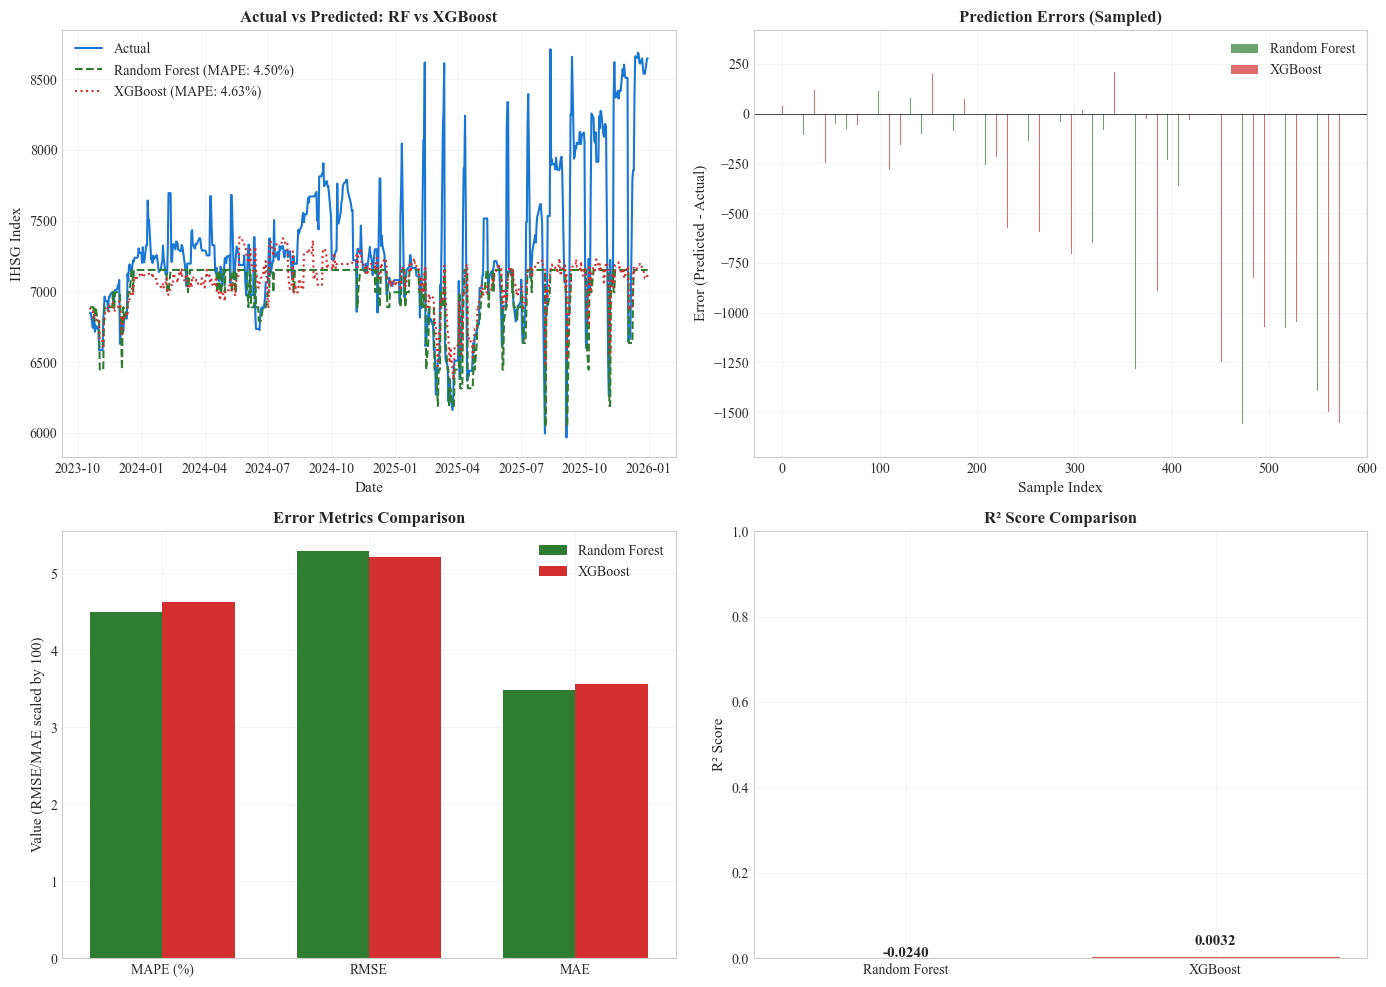

Figure saved: model2_comparison_rf_xgb.png (300 DPI)


In [ ]:
# =========================================================================
# VISUALIZATION: RANDOM FOREST vs XGBOOST
# =========================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predictions (Both Models)
ax1 = axes[0, 0]
ax1.plot(test_actual.time_index, test_actual.values(), 
         label='Actual', color=COLORS['actual'], linewidth=1.5)
ax1.plot(predictions.time_index, predictions.values(), 
         label=f'Random Forest (MAPE: {mape_score:.2f}%)', 
         color=COLORS['IHSG'], linewidth=1.5, linestyle='--')
ax1.plot(xgb_predictions.time_index, xgb_predictions.values(), 
         label=f'XGBoost (MAPE: {xgb_mape:.2f}%)', 
         color=COLORS['predicted'], linewidth=1.5, linestyle=':')
ax1.set_title('Actual vs Predicted: RF vs XGBoost', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('IHSG Index')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Prediction Errors
ax2 = axes[0, 1]
rf_errors = (predictions.values().flatten() - test_actual.values().flatten())
xgb_errors = (xgb_predictions.values().flatten() - test_actual.values().flatten())

# Sample for clearer visualization (daily data has many points)
sample_idx = np.arange(0, len(rf_errors), max(1, len(rf_errors)//50))
ax2.bar(sample_idx - 0.2, rf_errors[sample_idx], 0.4, 
        label='Random Forest', color=COLORS['IHSG'], alpha=0.7)
ax2.bar(sample_idx + 0.2, xgb_errors[sample_idx], 0.4, 
        label='XGBoost', color=COLORS['predicted'], alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Prediction Errors (Sampled)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Error (Predicted - Actual)')
ax2.legend(loc='upper right', framealpha=0.9)
ax2.grid(True, alpha=0.3)

# Plot 3: Metrics Comparison Bar Chart
ax3 = axes[1, 0]
metrics = ['MAPE (%)', 'RMSE', 'MAE']
rf_values = [mape_score, rmse_score/100, mae_score/100]
xgb_values = [xgb_mape, xgb_rmse/100, xgb_mae/100]
x = np.arange(len(metrics))
width = 0.35
bars1 = ax3.bar(x - width/2, rf_values, width, label='Random Forest', color=COLORS['IHSG'])
bars2 = ax3.bar(x + width/2, xgb_values, width, label='XGBoost', color=COLORS['predicted'])
ax3.set_ylabel('Value (RMSE/MAE scaled by 100)')
ax3.set_title('Error Metrics Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend(loc='upper right', framealpha=0.9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: R² Comparison
ax4 = axes[1, 1]
models = ['Random Forest', 'XGBoost']
r2_values = [r2, xgb_r2]
colors_bar = [COLORS['IHSG'], COLORS['predicted']]
bars = ax4.bar(models, r2_values, color=colors_bar, alpha=0.8)
ax4.set_ylabel('R² Score')
ax4.set_title('R² Score Comparison', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
for bar, val in zip(bars, r2_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model2-figure/model2_comparison_rf_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_comparison_rf_xgb.png (300 DPI)")

In [ ]:
# =========================================================================
# DIAGNOSIS: WHY PREDICTIONS MAY APPEAR SIMILAR?
# =========================================================================
print("="*70)
print("MODEL WINDOW AND HORIZON EXPLANATION")
print("="*70)

print("\n1. FORECAST HORIZON (output_chunk_length):")
print(f"   - Value: {OUTPUT_CHUNK_LENGTH} day")
print("   - Meaning: Model predicts 1 day ahead at a time")
print("   - Each prediction is for t+1 given data up to t")

print(f"\n2. LOOKBACK WINDOW (lags):")
print(f"   - Target lags: {best_params['lags']} days")
print(f"   - Covariate lags: {best_params['lags_past_covariates']} days")
print(f"   - Meaning: Model uses {best_params['lags']} days of IHSG history")
print(f"             and {best_params['lags_past_covariates']} days of covariate history")

print("\n3. HOW historical_forecasts WORKS:")
print("   Day 1: Use [t-10, t-9, ..., t-1, t] → Predict t+1")
print("   Day 2: Use [t-9, t-8, ..., t, t+1_actual] → Predict t+2")
print("   Day 3: Use [t-8, t-7, ..., t+1, t+2_actual] → Predict t+3")
print("   ...")
print("   (Sliding window, always predicting 1-step ahead)")

print("\n4. POTENTIAL CAUSES OF SIMILAR PREDICTIONS:")

# Check prediction variance
pred_values = predictions.values().flatten()
pred_diff = np.diff(pred_values)
zero_diff_pct = (np.abs(pred_diff) < 0.01).sum() / len(pred_diff) * 100

print(f"\n   a) Prediction Variance Analysis:")
print(f"      - Std of predictions: {pred_values.std():.2f}")
print(f"      - Std of actuals: {test_actual.values().flatten().std():.2f}")
print(f"      - % of consecutive predictions with <0.01 diff: {zero_diff_pct:.1f}%")

# Check if ffill caused many duplicates
df_check = df_ts.copy()
duplicate_pct = (df_check.diff() == 0).mean() * 100
print(f"\n   b) Data after ffill (% unchanged from previous day):")
for col in ['IHSG'] + COVARIATE_COLS:
    dup_pct = (df_check[col].diff() == 0).sum() / len(df_check) * 100
    print(f"      {col}: {dup_pct:.1f}%")

print("\n5. INTERPRETATION:")
print("   - Random Forest tends to predict 'smoothed' values")
print("   - With short lags (10 days), recent trends dominate")
print("   - Tree-based models may predict similar values when")
print("     input features are similar (especially after ffill)")
print("   - This is normal behavior for RF on financial time series")

print("\n" + "="*70)

MODEL WINDOW AND HORIZON EXPLANATION

1. FORECAST HORIZON (output_chunk_length):
   - Value: 1 day
   - Meaning: Model predicts 1 day ahead at a time
   - Each prediction is for t+1 given data up to t

2. LOOKBACK WINDOW (lags):
   - Target lags: 10 days
   - Covariate lags: 5 days
   - Meaning: Model uses 10 days of IHSG history
             and 5 days of covariate history

3. HOW historical_forecasts WORKS:
   Day 1: Use [t-10, t-9, ..., t-1, t] → Predict t+1
   Day 2: Use [t-9, t-8, ..., t, t+1_actual] → Predict t+2
   Day 3: Use [t-8, t-7, ..., t+1, t+2_actual] → Predict t+3
   ...
   (Sliding window, always predicting 1-step ahead)

4. POTENTIAL CAUSES OF SIMILAR PREDICTIONS:

   a) Prediction Variance Analysis:
      - Std of predictions: 228.20
      - Std of actuals: 522.10
      - % of consecutive predictions with <0.01 diff: 74.0%

   b) Data after ffill (% unchanged from previous day):
      IHSG: 20.9%
      STI: 20.9%
      Coal: 26.7%
      Copper: 21.3%
      Silver: 20.